<a href="https://colab.research.google.com/github/TienLungSun/AI-Lecture-notes/blob/main/Slowfast_colab%20(Step%20by%20step%20%E5%AD%B8%E7%BF%92).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: https://github.com/facebookresearch/pytorchvideo/blob/master/tutorials/video_detection_example/video_detection_inference_tutorial.ipynb

In [1]:
#安裝 Detectron2, this takes about 3 min
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-1yy36nmz
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-1yy36nmz
     |████████████████████████████████| 49 kB 2.7 MB/s 
     |████████████████████████████████| 74 kB 3.1 MB/s 
     |████████████████████████████████| 145 kB 39.8 MB/s 
     |████████████████████████████████| 130 kB 45.3 MB/s 
     |████████████████████████████████| 745 kB 37.1 MB/s 
     |████████████████████████████████| 743 kB 38.7 MB/s 
     |████████████████████████████████| 636 kB 39.4 MB/s 
     |████████████████████████████████| 112 kB 47.5 MB/s 
  Created wheel for detectron2: filename=detectron2-0.5-cp37-cp37m-linux_x86_64.whl size=5511773 sha256=34628598397d45afa6a501bd6d2af8060cd4371aac363273dba98dcff1f4d045
  Stored in directory: /tmp/pip-ephem-wheel-cache-5i84ad7a/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7d149d69c27ca5d
  Created wheel for fvcore: filename=fvcore

In [2]:
#執行這一行前, 要把 visualization.py 上傳 Colab
!python visualization.py

In [3]:
!pip install pytorchvideo

     |████████████████████████████████| 115 kB 5.9 MB/s 
     |████████████████████████████████| 37.2 MB 28 kB/s 
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.2-py3-none-any.whl size=166136 sha256=0b7c139c5078591080833766abf2959b335572fd9cc0061d881c06553254d908
  Stored in directory: /root/.cache/pip/wheels/4c/f5/ee/ee524d0e7df398623c64816181cd6a99fb9b7eab56d0608ace
Successfully built pytorchvideo


In [4]:
from functools import partial
import numpy as np
import imageio
import cv2
import torch

import detectron2
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor

from IPython import display
import matplotlib.pyplot as plt

In [5]:
import pytorchvideo
from pytorchvideo.transforms.functional import (
    uniform_temporal_subsample,
    short_side_scale_with_boxes,
    clip_boxes_to_image,
)
from torchvision.transforms._functional_video import normalize
from pytorchvideo.data.ava import AvaLabeledVideoFramePaths
from pytorchvideo.models.hub import slow_r50_detection,slowfast_r50_detection # Another option is slowfast_r50_detection

from visualization import VideoVisualizer

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The _functional_video module is deprecated. Please use the functional module instead.
  "The _functional_video module is deprecated. Please use the functional module instead."


Load Model using Torch Hub API

PyTorchVideo provides several pretrained models through Torch Hub. Available models are described in model zoo documentation.

Here we are selecting the slow_r50_detection model which was trained using a 4x16 setting on the Kinetics 400 dataset and fine tuned on AVA V2.2 actions dataset.

In [6]:
device = 'cuda' # or 'cpu'
video_model = slowfast_r50_detection(True) # Another option is slowfast_r50_detection
#video_model = slow_r50_detection(True) # Another option is slowfast_r50_detection
video_model = video_model.eval().to(device)

Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/ava/SLOWFAST_8x8_R50_DETECTION.pyth" to /root/.cache/torch/hub/checkpoints/SLOWFAST_8x8_R50_DETECTION.pyth


  0%|          | 0.00/259M [00:00<?, ?B/s]

Load an off-the-shelf Detectron2 object detector

We use the object detector to detect bounding boxes for the people. These bounding boxes later feed into our video action detection model. For more details, please refer to the Detectron2's object detection tutorials.

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.55  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_280758.pkl: 167MB [00:06, 24.0MB/s]                           


In [8]:
# This method takes in an image and generates the bounding boxes for people in the image.
def get_person_bboxes(inp_img, predictor):
    predictions = predictor(inp_img.cpu().detach().numpy())['instances'].to('cpu')
    boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
    scores = predictions.scores if predictions.has("scores") else None
    classes = np.array(predictions.pred_classes.tolist() if predictions.has("pred_classes") else None)
    predicted_boxes = boxes[np.logical_and(classes==0, scores>0.75 )].tensor.cpu() # only person
    return predicted_boxes

Define the transformations for the input required by the model

Before passing the video and bounding boxes into the model we need to apply some input transforms and sample a clip of the correct frame rate in the clip.

Here, below we define a method that can pre-process the clip and bounding boxes. It generates inputs accordingly for both Slow (Resnet) and SlowFast models depending on the parameterization of the variable slow_fast_alpha.

In [9]:
def ava_inference_transform(
    clip, 
    boxes,
    #num_frames = 4, #if using slow_r50_detection, change this to 4
    num_frames = 32, #if using slowfast_r50_detection, change this to 32
    crop_size = 256, 
    data_mean = [0.45, 0.45, 0.45], 
    data_std = [0.225, 0.225, 0.225],
    #slow_fast_alpha = None, #if using slow_r50_detection, change this to None
    slow_fast_alpha = 4, #if using slowfast_r50_detection, change this to 4
):

    boxes = np.array(boxes)
    ori_boxes = boxes.copy()

    # Image [0, 255] -> [0, 1].
    clip = uniform_temporal_subsample(clip, num_frames)
    clip = clip.float()
    clip = clip / 255.0

    height, width = clip.shape[2], clip.shape[3]
    # The format of boxes is [x1, y1, x2, y2]. The input boxes are in the
    # range of [0, width] for x and [0,height] for y
    boxes = clip_boxes_to_image(boxes, height, width)

    # Resize short side to crop_size. Non-local and STRG uses 256.
    clip, boxes = short_side_scale_with_boxes(
        clip,
        size=crop_size,
        boxes=boxes,
    )
    
    # Normalize images by mean and std.
    clip = normalize(
        clip,
        np.array(data_mean, dtype=np.float32),
        np.array(data_std, dtype=np.float32),
    )
    
    boxes = clip_boxes_to_image(
        boxes, clip.shape[2],  clip.shape[3]
    )
    
    # Incase of slowfast, generate both pathways
    if slow_fast_alpha is not None:
        fast_pathway = clip
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            clip,
            1,
            torch.linspace(
                0, clip.shape[1] - 1, clip.shape[1] // slow_fast_alpha
            ).long(),
        )
        clip = [slow_pathway, fast_pathway]
    
    return clip, torch.from_numpy(boxes), ori_boxes

Download the id to label mapping for the AVA V2.2 dataset on which the Torch Hub models were finetuned. This will be used to get the category label names from the predicted class ids.

Create a visualizer to visualize and plot the results(labels + bounding boxes).

In [10]:
# Create an id to label name mapping
# 記得把 ava_action_list.txt 上傳到 Colab
label_map, allowed_class_ids = AvaLabeledVideoFramePaths.read_label_map('ava_action_list.txt')

In [11]:
# Create a video visualizer that can plot bounding boxes and visualize actions on bboxes.
video_visualizer = VideoVisualizer(81, label_map, top_k=3, mode="thres",thres=0.5)

Load video

In [12]:
from google.colab import files
uploaded = files.upload()
fnameLst = list(uploaded.keys())
video_name = fnameLst[0]
print(video_name)

Saving RROldies-short.mp4 to RROldies-short.mp4
RROldies-short.mp4


In [13]:
encoded_vid = pytorchvideo.data.encoded_video.EncodedVideo.from_path(video_name)
encoded_vid.get_clip(0,1)['video'].shape

torch.Size([3, 11, 820, 1466])


#Generate bounding boxes and action predictions for all clips in the video.

In [14]:
vid = imageio.get_reader(video_name, 'ffmpeg')
fps = vid.get_meta_data()['fps']
print(fps)

<imageio.plugins.ffmpeg.FfmpegFormat.Reader object at 0x7f7136df2490> 10.0


In [18]:
int(encoded_vid.duration)

11

In [23]:
time_stamp = 0
clip_duration = 1.0 # Duration of clip used for each inference step.
inp_imgs = encoded_vid.get_clip(
        time_stamp - clip_duration/2.0, # start second
        time_stamp + clip_duration/2.0  # end second
    )

In [25]:
for key, value in inp_imgs.items():
  print(key)

video
audio


In [26]:
inp_imgs = inp_imgs['video']
print(inp_imgs.shape)

torch.Size([3, 6, 820, 1466])


In [27]:
inp_img = inp_imgs[:,inp_imgs.shape[1]//2,:,:]
print(inp_img.shape)

inp_img = inp_img.permute(1,2,0)
print(inp_img.shape)

torch.Size([3, 820, 1466])
torch.Size([820, 1466, 3])


In [28]:
predicted_boxes = get_person_bboxes(inp_img, predictor)
print(len(predicted_boxes))

5


/usr/local/lib/python3.7/dist-packages/detectron2/structures/boxes.py:244: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  b = self.tensor[item]


In [31]:
# Preprocess clip and bounding boxes for video action recognition.
inputs, inp_boxes, _ = ava_inference_transform(inp_imgs, predicted_boxes.numpy())
print(len(inputs), inp_boxes.shape)

2 torch.Size([5, 4])


In [32]:
# Prepend data sample id for each bounding box. 
# For more details refere to the RoIAlign in Detectron2
inp_boxes = torch.cat([torch.zeros(inp_boxes.shape[0],1), inp_boxes], dim=1)
print(len(inp_boxes))

5


In [33]:
isinstance(inputs, list)

True

In [35]:
inputs = [inp.unsqueeze(0).to(device) for inp in inputs]
print(len(inputs))

2


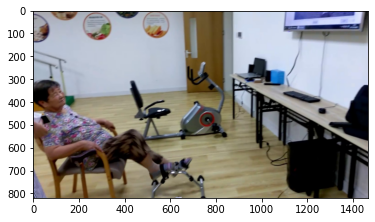

Finished generating predictions.


In [15]:
clip_duration = 1.0 # Duration of clip used for each inference step.
picture_count =0

videoFname = "Result.mp4"  
Writer = imageio.get_writer(videoFname, fps=fps)

# Video predictions are generated at an internal of 1 sec from 0 seconds to the end seconds in the video.
for time_stamp in range(int(encoded_vid.duration)):  # time stamps in video for which clip is sampled. 
    print("Generating predictions for time stamp: {} sec".format(time_stamp))
    
    # Generate clip around the designated time stamps
    inp_imgs = encoded_vid.get_clip(
        time_stamp - clip_duration/2.0, # start second
        time_stamp + clip_duration/2.0  # end second
    )
    inp_imgs = inp_imgs['video']
    
    # Generate people bbox predictions using Detectron2's off the self pre-trained predictor
    # We use the the middle image in each clip to generate the bounding boxes.
    inp_img = inp_imgs[:,inp_imgs.shape[1]//2,:,:]
    inp_img = inp_img.permute(1,2,0)
    
    # Predicted boxes are of the form List[(x_1, y_1, x_2, y_2)]
    predicted_boxes = get_person_bboxes(inp_img, predictor) 
    if len(predicted_boxes) == 0: 
        print("Skipping clip no frames detected at time stamp: ", time_stamp)
        continue
        
    # Preprocess clip and bounding boxes for video action recognition.
    inputs, inp_boxes, _ = ava_inference_transform(inp_imgs, predicted_boxes.numpy())
    # Prepend data sample id for each bounding box. 
    # For more details refere to the RoIAlign in Detectron2
    inp_boxes = torch.cat([torch.zeros(inp_boxes.shape[0],1), inp_boxes], dim=1)
    
    # Generate actions predictions for the bounding boxes in the clip.
    # The model here takes in the pre-processed video clip and the detected bounding boxes.
    if isinstance(inputs, list):
        inputs = [inp.unsqueeze(0).to(device) for inp in inputs]
    else:
        inputs = inputs.unsqueeze(0).to(device)
    preds = video_model(inputs, inp_boxes.to(device))

    preds= preds.to('cpu')
    # The model is trained on AVA and AVA labels are 1 indexed so, prepend 0 to convert to 0 index.
    preds = torch.cat([torch.zeros(preds.shape[0],1), preds], dim=1)
    
    # Plot predictions on the video and save for later visualization.
    inp_imgs = inp_imgs.permute(1,2,3,0)
    inp_imgs = inp_imgs/255.0
    out_img_pred = video_visualizer.draw_clip_range(inp_imgs, preds, predicted_boxes)
    
    out_img_pred = np.array(out_img_pred)
    for index in range(out_img_pred.shape[0]):
        display.clear_output(wait=True)
        img = out_img_pred[index]
        img = (255*img).astype(np.uint8)
        Writer.append_data(img)
        plt.imshow(img) 
        plt.pause(0.0001)
        picture_count += 1

print("Finished generating predictions.")
Writer.close()

In [17]:
preds = video_model(inputs, inp_boxes.to(device))

RuntimeError: ignored